In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import MINST data, split it into X ad Y, isolate X1, X2 and X3 from X <br>
where X1 = subdata of X containing 0, X2 = 6, X3 = 9

In [69]:


#dataset has 42000 images, each of resolution 28*28 pixels (784 flattened pixels per image)
#flattening: take a matrix and convert it to a vector
#datasets of images are always flattened
#each image is labelled (the label says which number is rapresented), so we have 785 columns in total
#we're gonna split the data intto a matrix X and a vector Y, where:
#X is of dimension (42000, 784) -> just images
#Y is of dimension (42000, ) -> just label [first column of the 785]

#function to randomly divide data into test and train sets
def trainTestSets(X, Y, perc,N):
    #divide in Xtrain and Xtest
    trainSize=int(perc*N/100)
    Xtrain=X[:,:trainSize]
    Ytrain=Y[:trainSize]
    Xtest=X[:,trainSize:N]
    Ytest=Y[trainSize:N]
    return Xtrain, Ytrain, Xtest, Ytest

#load data into memory
data=pd.read_csv("data.csv")
#print(data.head())
#convert data into matrix
data=np.array(data)
np.random.shuffle(data)
#split data into X and Y
X=data[:,1:].T 
Y=data[:,0]


#isolate X1, X2, X3
i1= (Y==0)
print(i1)
i2= (Y==6)
i3= (Y==9)
X=X[:, i1+i2+i3]
Y=Y[i1+i2+i3]
d,N=X.shape
print(N)
#divide in train and test sets
Xtrain, Ytrain, Xtest, Ytest = trainTestSets(X,Y,60,N)
print(Xtrain.shape)
i1= (Ytrain==0)
i2= (Ytrain==6)
i3= (Ytrain==9)
X1=Xtrain[:, i1]
X2=Xtrain[:, i2]
X3=Xtrain[:, i3]

Y1=Ytrain[i1]
Y2=Ytrain[i2]
Y3=Ytrain[i3]


#concatenate the 3 matrices by column, to order them based on the label
Xtrain=np.concatenate((X1,X2,X3), axis=1)
Ytrain=np.concatenate((Y1,Y2,Y3))

[ True False False ... False  True False]
12457
(784, 7474)


Calculate the centroid and get the centered matrix Xc

In [70]:
#calculate global and class centroids

#global centroid
C=np.mean(Xtrain, axis=1) #mean on axis=1 means doing the mean pixel-by-pixel of every image, obtaining a single image (array of 784 pixels)
print(C.shape)
#class centroids
C1=np.mean(X1, axis=1)
C2=np.mean(X2, axis=1)
C3=np.mean(X3, axis=1)
#global centered data
Xc=Xtrain-C.reshape((d,1)) #reshape C because we can't subtract a vector


(784,)


Use SVD to decompose the Xc matrix in 3 matrices: U, s and VT

In [71]:
#SVD of a matrix A:
#U, s, V= np.linalg.svd(A)
#use only the centered training data Xc
k=2
Xk=Xc[:,:k]
print(Xk.shape)
Uk, s, VT = np.linalg.svd(Xk, full_matrices=False)
print(Uk.shape)
#Uk=U[:,:k]
#print(Uk.shape)


(784, 2)
(784, 2)


Uk is the projection matrix.<br>
Now we want to project X in 2D (k=2), by multiplying it with the (transposed) projection matrix.

(2, 7474)
(2, 1)


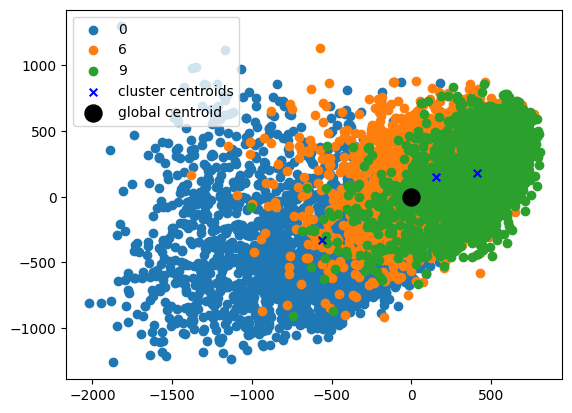

In [75]:
Z=Uk.T@Xc
print(Z.shape)
#plot
Z1=Z[:,Ytrain==0]
Z2=Z[:,Ytrain==6]
Z3=Z[:,Ytrain==9]
plt.scatter(Z1[0,:], Z1[1,:], label="0") #c means color -> we color the data based on the label
plt.scatter(Z2[0,:], Z2[1,:], label="6") #c means color -> we color the data based on the label
plt.scatter(Z3[0,:], Z3[1,:], label="9") #c means color -> we color the data based on the label

#calculate centroids
C1z=np.mean(Z1, axis=1).reshape(k,1)
C2z=np.mean(Z2, axis=1).reshape(k,1)
C3z=np.mean(Z3, axis=1).reshape(k,1)
Cz=np.mean(Z, axis=1).reshape(k,1)
print(C1z.shape)

plt.scatter(C1z[0], C1z[1], c="blue",s=30, marker="x", label="cluster centroids")
plt.scatter(C2z[0], C2z[1], c="blue",s=30, marker="x")
plt.scatter(C3z[0], C3z[1], c="blue",s=30, marker="x")
plt.scatter(Cz[0], Cz[1], c="black",s=150, marker="o", label="global centroid")
plt.legend()
plt.show()

Clusters overlap on each other, in fact PCA should not be used for clustering, but it's good for dimensionality reduction.<br>
Cluster centroids are too near to each other, and visually is difficult to understand to which cluster they belong to.

In [73]:
D1=0
for i in Z1[1]:
    D1+=np.linalg.norm(C1z-Z1)**2
D1=D1/Z1.shape[1]
print(f"average distance form C1: {D1}")

D2=0
for i in Z2[1]:
    D2+=np.linalg.norm(C2z-Z2)**2
D2=D2/Z2.shape[1]
print(f"average distance form C2: {D2}")

D3=0
for i in Z3[1]:
    D3+=np.linalg.norm(C3z-Z3)**2
D3=D3/Z3.shape[1]
print(f"average distance form C3: {D3}")

average distance form C1: 958215459.6496252
average distance form C2: 460043699.0427009
average distance form C3: 323793106.4612228


(2,) (2, 1)
4983
1643
prediction accuracy = 0.3297210515753562


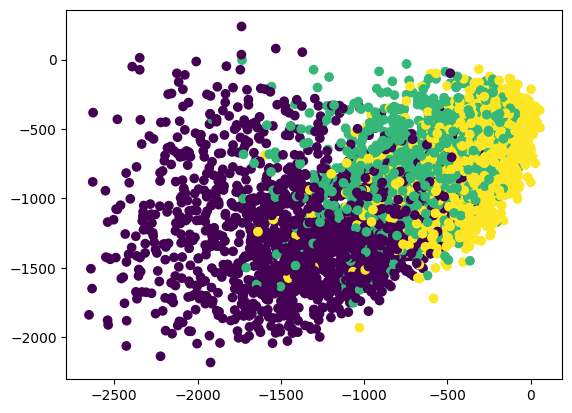

In [74]:
def min(vec):
    min=100000000
    ind=0
    for i in vec:
        if i<min:
            min=i
            minInd=ind
        ind+=1
    return minInd

#project Xtest 
Ztest=Uk.T@Xtest
testSize=Ztest.shape[1]
#predict results
Ypredict=[]
print(Ztest[:,0].shape, C1z.shape)
for i in range(testSize):
    D1=np.linalg.norm(Ztest[:,i]-C1z)**2
    D2=np.linalg.norm(Ztest[:,i]-C2z)**2
    D3=np.linalg.norm(Ztest[:,i]-C3z)**2

    minInd=min([D1,D2,D3])  
    if(minInd==0):
        Ypredict.append(0)
    elif(minInd==1):
        Ypredict.append(6)
    else:
        Ypredict.append(9)
print(len(Ypredict))
#calculate accuracy
sum=0
i=0
for y in Ypredict:
    if(y==Ytest[i]):
        sum+=1
    i+=1
print(sum)
accuracy=sum/testSize
print(f"prediction accuracy = {accuracy}")

plt.scatter(Ztest[0,:], Ztest[1,:], c=Ytest)